## Computer Vision Pytorch libraries
### torchvision
`torchvision.datasets`get datasets and data loading functions for computer vision

`torchvision.models`get pretrained computer vision models that you can leverage for your own problems

`torchvision.transforms`functions for manipulating your vision data (images) to be suitable for use with an ML model

`torchvision.utils`helper functions for viewing images

`torch.utils.data.Dataset`base dataset class for PyTorch

`torch.utils.data.DataLoader`create a Python iterable over a dataset


In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt



In [2]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


### Getting Dataset: FashionMNIST

In [3]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)


In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
image, label = train_data[0]

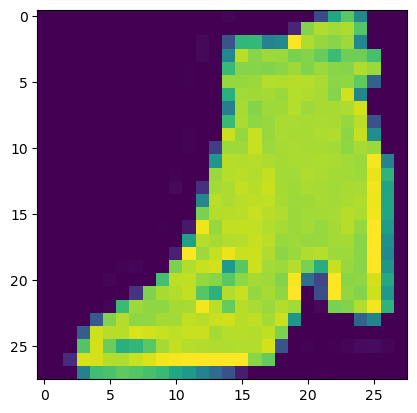

In [6]:
plt.imshow(train_data[33313][0].permute(1, 2, 0))

In [7]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
class_to_idx = {class_name: idx for idx, class_name in enumerate(train_data.classes)}
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [9]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [10]:
image.shape, label
print(f"Image shape: {image.shape} = [Color channels, Height, Width] and label: {label} = {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) = [Color channels, Height, Width] and label: 9 = Ankle boot


### Visualizing Data

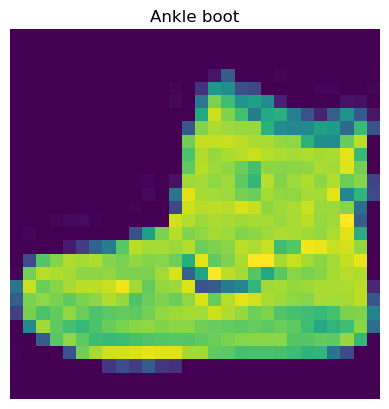

In [11]:
import matplotlib.pyplot as plt
image, label = train_data[0]
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
plt.show()

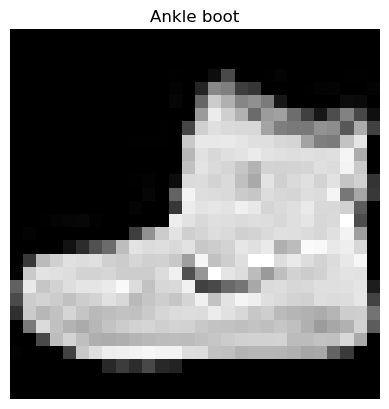

In [12]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
plt.show()

### Plot more images

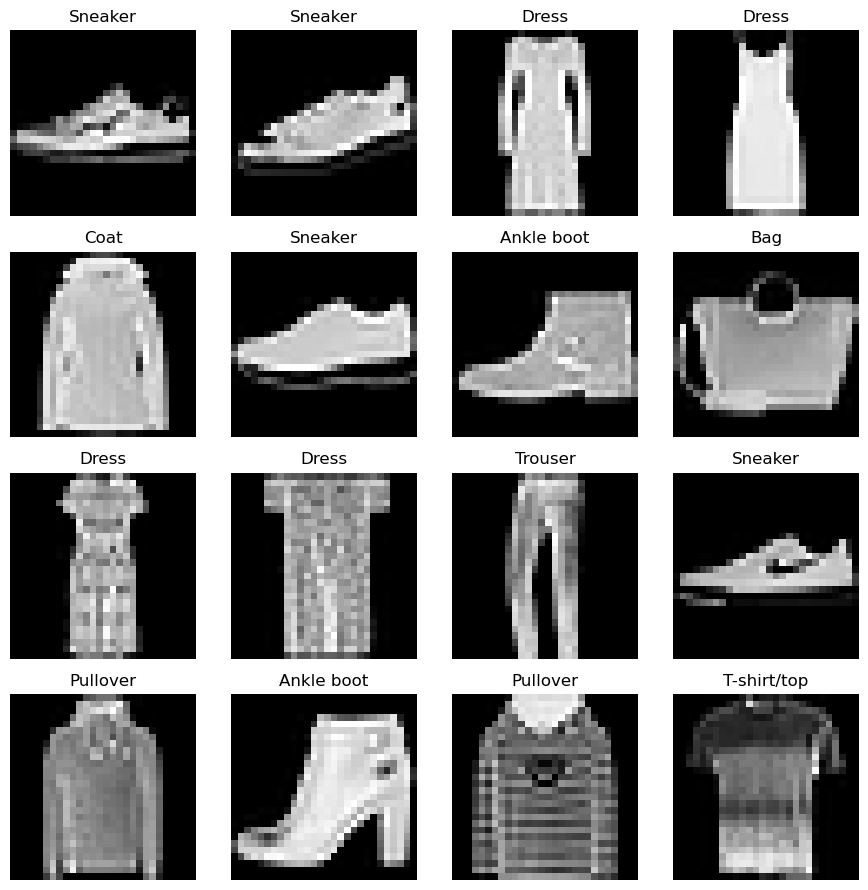

In [13]:
torch.manual_seed(38)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)
plt.tight_layout()
plt.show()

### Prepare DataLoader

In [14]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

### Need to turn data into groups of batches = mini-batches
-> Computationally efficient, not able to look and store in memory 60'000 images. 
-> Idea: break it down into 32 images at a time (batch size = 32)
---> Gives our neural network 

`shuffle=True` -> mix up the data so that the model doesn't learn anything

In [15]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x70d7e1b039e0>,
 <torch.utils.data.dataloader.DataLoader at 0x70d7e46ac560>)

In [16]:
print(f"DataLoaders: {train_dataloader, test_dataloader}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x70d7e1b039e0>, <torch.utils.data.dataloader.DataLoader object at 0x70d7e46ac560>)


In [17]:
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE} images")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE} images")

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

Length of train_dataloader: 1875 batches of 32 images
Length of test_dataloader: 313 batches of 32 images


(torch.Size([32, 1, 28, 28]), torch.Size([32]))

### Show a sample

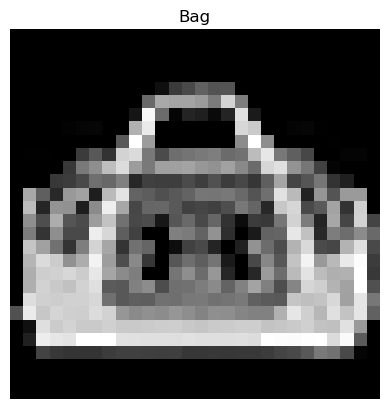

Image size: torch.Size([1, 28, 28]) = [Color channels, Height, Width]
Label: 8 = Bag


In [18]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
plt.show()

print(f"Image size: {img.shape} = [Color channels, Height, Width]")
print(f"Label: {label} = {class_names[label]}")



### Model 0: Build a baseline model = simple model to improve with subsequent models/experiments
* Create a flatten model
* Create a Sequential model
* Create a forward method
* Setup a loss function and optimizer
* Training and testing loop


In [19]:
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Print out original shape
print(f"Shape before flattening: {x.shape}, color channel, height, width")

# Flatten the sample
output = flatten_model(x)

# Print out new shape
print(f"Shape after flattening: {output.shape}")


Shape before flattening: torch.Size([1, 28, 28]), color channel, height, width
Shape after flattening: torch.Size([1, 784])


In [20]:
from torch import nn

class FashionMNISTModelV0(nn.Module): 
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)




In [21]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape=28*28, hidden_units=10, output_shape=len(class_names))
model_0.to("cpu")



FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [22]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [23]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### Setup loss function and optimizer + optimizer metrics

* Loss function: multi-class data, loss function would be `ǹn.CrossEntropyLoss()`
* Optimizer: stochastic gradient descent, `torch.optim.SGD()`
* Evaluation metrics: accuracy 

In [24]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f: # wb = write binary, as f = file
        f.write(request.content)

helper_functions.py already exists, skipping download


### Import accuracy metrics

In [25]:
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


### Time our experiments
 
 * Model's performance (loss and accuracy values)
 * How fast it runs (speed)


In [26]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time."""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [27]:
start_time = timer()

# Training


end_time = timer()
print_train_time(start_time, end_time, device="cpu")


Train time on cpu: 0.000 seconds


1.592100306879729e-05

### Creating training loop and training model on batches of data 

1. Loop through epochs
2. Loop through training batches, perform training steps, calculate the train loss per batch
3. Loop through testing batches, perform testing steps, calculate the test loss per batch
4. Print out what's happening
5. Time it all


### import tqdm for progress bar

In [28]:
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    ### Training
    train_loss = 0
    # Add a loop through the training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)

    ### Testing
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
            # 2. Calculate loss
            test_loss += loss_fn(test_pred, y)
            # 3. Calculate accuracy
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    # Calculate averages outside of inference mode
    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}%\n")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.0387%

Epoch: 1
----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.1969%

Epoch: 2
----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.4265%

Train time on cpu: 14.240 seconds


### Make predictions and get Model 0 results

In [29]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Make predictions
            y_pred = model(X)
            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss and acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, "model_loss": loss.item(), "model_acc": acc}

model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results





  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

### Setup device agnostic code (for using GPU)

In [30]:
!nvidia-smi
torch.cuda.is_available()

Sun Feb  9 15:59:43 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P8               9W /  40W |      9MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

In [31]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Building a better model with non-linearity

In [32]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()   
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

        





In [33]:
# Create an instance of FashionMNISTModelV1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=28*28, hidden_units=10, output_shape=len(class_names)).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### Setup loss, optimizer and evaluation metrics


In [34]:
from helper_functions import accuracy_fn

#measure how wrong our model is
loss_fn = nn.CrossEntropyLoss() 

# tries to improve the model by adjusting the parameters to reduce the loss
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1) 

### Functionizing training and eval/testing loop

* Create function for: 

- Training loop - `train_step()`
- Testing loop - `test_step()`
- Evaluation loop - `eval_model()`



### Train step

In [41]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
               # Performs a training with model trying to learn on data_loader
    train_loss, train_acc = 0, 0

    # put model in train mode
    model.train()

    # Add a loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate loss and accuracy per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
        # print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples")

    # Divide total train loss by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc





### Test step

In [40]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    test_loss, test_acc = 0, 0

    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)
            # 2. Calculate loss and accuracy per batch
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true = y, y_pred=test_pred.argmax(dim=1))

        # Adjust metrics and print out what's happening
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}%\n")

    return test_loss, test_acc


### Evaluation loop

In [42]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set the number of epochs
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    train_step(model=model_1,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_1,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

# Calculate training time
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Test loss: 0.9564, Test acc: 64.9960%

Epoch: 1
----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Test loss: 0.7223, Test acc: 73.9117%

Epoch: 2
----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Test loss: 0.6850, Test acc: 75.0200%

Train time on cuda: 14.272 seconds


In [43]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

In [46]:
total_train_time_model_0

14.240476110993768

### Depending on data/hardware, it's possible that the model trains faster on CPU than GPU

* Overhead for copying data/model to and from the GPU

### Get model_1 results dictionary

In [56]:
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)

model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008368492126,
 'model_acc': 75.01996805111821}

In [57]:
model_0_results


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

# Model 2: Convolutional Neural Network

### Create a convolutional neural network

In [101]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            # Values we can set ourselves in our NN's are called hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # !!!!!!! 7*7 is the size of the image after going through the convolutional layers, to be matched with the output shape
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x



In [60]:
image.shape

torch.Size([1, 28, 28])

In [61]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [62]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

### Stepping through nn.Conv2d

In [63]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Shape of test image: {test_image.shape}")

# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,out_channels=10, kernel_size=3, stride=1, padding=1)

# Pass the test image through the conv layer
conv_layer(test_image)

Shape of test image: torch.Size([3, 64, 64])


tensor([[[ 1.6446e-01, -6.2518e-01, -7.7713e-01,  ..., -3.2504e-01,
          -3.1604e-01,  4.5352e-01],
         [ 3.5455e-01, -2.8778e-01, -6.0596e-02,  ...,  6.6224e-01,
          -2.3216e-01,  7.7080e-01],
         [-4.5420e-02, -9.8911e-01, -4.0099e-01,  ..., -1.8552e-01,
          -5.7622e-01,  4.2301e-01],
         ...,
         [ 2.9288e-01, -1.4512e-01, -1.1566e-01,  ..., -3.6626e-01,
           3.5645e-01,  2.8384e-01],
         [ 2.0746e-01,  3.6096e-02,  1.5214e-01,  ..., -4.9680e-01,
          -7.2258e-01, -8.3858e-02],
         [-3.2457e-01, -3.2326e-01,  9.5475e-02,  ...,  5.9960e-01,
           3.2819e-01,  3.6604e-01]],

        [[ 1.2406e+00,  2.2794e-01, -1.8362e-01,  ..., -6.3520e-01,
          -7.5413e-01,  4.0612e-01],
         [ 4.1380e-01, -1.0853e+00, -1.6079e+00,  ..., -1.7643e+00,
           2.5263e-01,  3.8844e-01],
         [ 5.3442e-01, -8.2507e-01,  6.3866e-01,  ...,  4.8068e-01,
           8.4869e-01, -1.5706e-01],
         ...,
         [-5.6923e-03, -5

In [64]:
conv_output = conv_layer(test_image.unsqueeze(0))
conv_output.shape


torch.Size([1, 10, 64, 64])

In [65]:
torch.__version__

'2.5.1+cu124'

## Stepping through `nn.MaxPool2d`

In [66]:
test_image.shape

torch.Size([3, 64, 64])

### Print out original image shape without unsqueeze dimension

In [67]:
print(f"Shape of test image: {test_image.shape}")
print(f"Shape of test image with unsqueeze: {test_image.unsqueeze(0).shape}")

Shape of test image: torch.Size([3, 64, 64])
Shape of test image with unsqueeze: torch.Size([1, 3, 64, 64])


In [68]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)

In [70]:
print(f"Shape of test image: {test_image.shape}")
print(f"Shape of test image with unsqueeze: {test_image.unsqueeze(0).shape}")

# Pass the data through the max pool layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape of test image after conv layer: {test_image_through_conv.shape}")

test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape of test image after conv layer and max pool layer: {test_image_through_conv_and_max_pool.shape}")



Shape of test image: torch.Size([3, 64, 64])
Shape of test image with unsqueeze: torch.Size([1, 3, 64, 64])
Shape of test image after conv layer: torch.Size([1, 10, 64, 64])
Shape of test image after conv layer and max pool layer: torch.Size([1, 10, 32, 32])


In [76]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Initial tensor:\n {random_tensor}")
print(f"Shape of tensor: {random_tensor.shape}\n")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)

print(f"Shape of tensor: {random_tensor.shape}")
print(f"Shape of tensor after max pool layer: {max_pool_tensor.shape}")

Initial tensor:
 tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Shape of tensor: torch.Size([1, 1, 2, 2])

Shape of tensor: torch.Size([1, 1, 2, 2])
Shape of tensor after max pool layer: torch.Size([1, 1, 1, 1])


In [77]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)

model_2

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

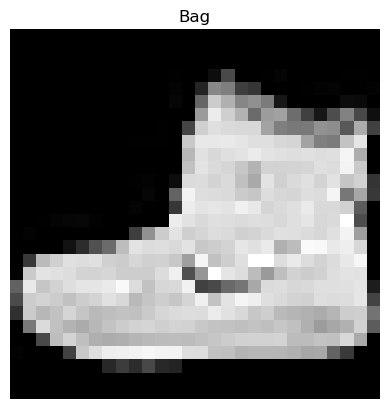

In [78]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
plt.show()

In [82]:
model_2 = model_2.to(device)
image = image.to(device)
output = model_2(image.unsqueeze(0))
output


Output shape of conv_block_1: torch.Size([1, 10, 14, 14])
Output shape of conv_block_2: torch.Size([1, 10, 7, 7])
Output shape of classifier: torch.Size([1, 10])


tensor([[ 0.0246, -0.0644,  0.0551, -0.0360, -0.0139,  0.0113, -0.0014, -0.0075,
          0.0213,  0.0076]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Setup loss function / eval metrics / optimizer

In [84]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss() # multiclass classification problem
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)


In [85]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

### Training and testing model_2 using our training and test functions

In [87]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Set the number of epochs
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    train_step(model=model_2,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_2,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

# Calculate training time
train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end=train_time_end_model_2,
                                            device=device)

### Get model_2 results
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)

model_2_results
model_1_results
model_0_results

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Looked at 0/60000 samples
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape 

  0%|          | 0/313 [00:00<?, ?it/s]

Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output sha

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

### Get model_2 results 

In [88]:
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output sha

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3164254128932953,
 'model_acc': 88.49840255591054}

## Comparing model results and training time

In [90]:
import pandas as pd 

compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results


,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.316425,88.498403


### Add training time to results comparison

In [91]:
compare_results["training_time"] = [total_train_time_model_0, total_train_time_model_1, total_train_time_model_2]
compare_results


,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,14.240476
1,FashionMNISTModelV1,0.685001,75.019968,14.271914
2,FashionMNISTModelV2,0.316425,88.498403,20.054880


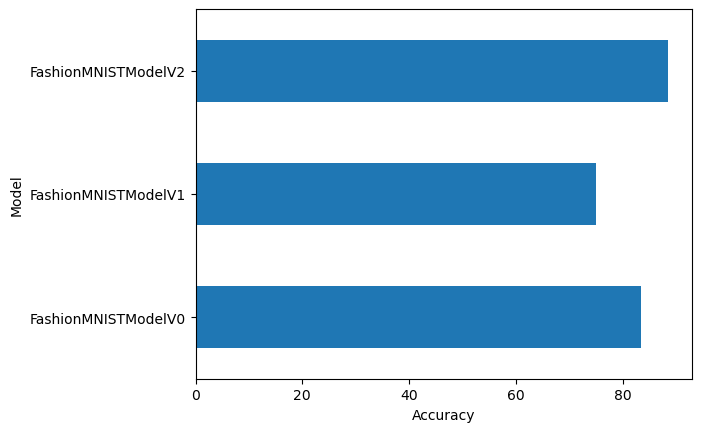

In [94]:
compare_results.set_index("model_name")["model_acc"].plot(kind = "barh")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.show()


## Make and evaluate random predictions with the best performing model

In [96]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and send to device)
            sample = torch.unsqueeze(sample, dim=0).to(device)
            # Forward pass (model outputs raw logits)
            pred_logits = model(sample)
            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [97]:
img, label = test_data[0]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [98]:
import random
random.seed(42)
test_samples = []
test_labels = []
random_samples = random.sample(list(range(len(test_data))), k=9)
for idx in random_samples:
    test_samples.append(test_data[idx][0])
    test_labels.append(test_data[idx][1])

# View the first sample shape    
test_samples[0].shape


torch.Size([1, 28, 28])

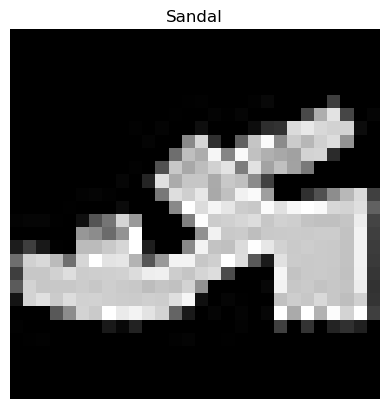

In [99]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])
plt.axis(False)
plt.show()

### Make predictions

In [102]:
pred_probs = make_predictions(model=model_2, data=test_samples)

# View first two prediction probabilities
pred_probs[:2]



Output shape of conv_block_1: torch.Size([1, 10, 14, 14])
Output shape of conv_block_2: torch.Size([1, 10, 7, 7])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv_block_1: torch.Size([1, 10, 14, 14])
Output shape of conv_block_2: torch.Size([1, 10, 7, 7])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv_block_1: torch.Size([1, 10, 14, 14])
Output shape of conv_block_2: torch.Size([1, 10, 7, 7])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv_block_1: torch.Size([1, 10, 14, 14])
Output shape of conv_block_2: torch.Size([1, 10, 7, 7])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv_block_1: torch.Size([1, 10, 14, 14])
Output shape of conv_block_2: torch.Size([1, 10, 7, 7])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv_block_1: torch.Size([1, 10, 14, 14])
Output shape of conv_block_2: torch.Size([1, 10, 7, 7])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv_block_1

tensor([[4.3061e-11, 3.2017e-10, 1.5927e-09, 2.3357e-10, 2.0836e-10, 1.0000e+00,
         1.6238e-09, 7.1298e-08, 2.2380e-07, 2.9289e-06],
        [3.4749e-03, 6.2441e-01, 5.6616e-03, 6.7825e-02, 2.6323e-01, 1.9943e-05,
         3.5279e-02, 3.9870e-05, 2.7603e-05, 3.1437e-05]])

In [103]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 6, 4, 7, 1])

In [104]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

### Plot predictions

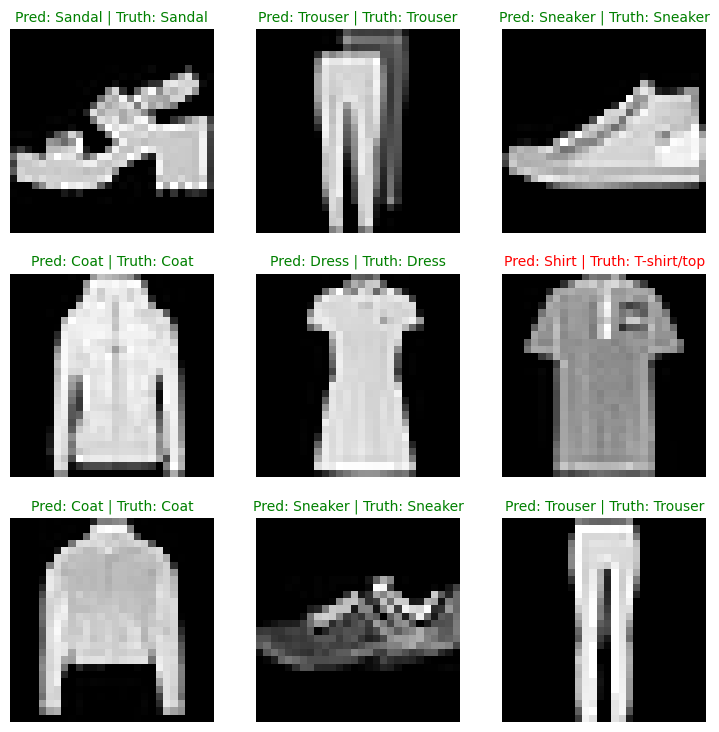

In [106]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)
    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")
    # Find the prediction label (in text form)
    pred_label = class_names[pred_classes[i]]
    # Get the truth label (in text form)
    truth_label = class_names[test_labels[i]]
    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    # Check if prediction label and truth label are the same
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if incorrect
    plt.axis(False)
plt.show()

## Making a confusion matrix for a multiclass classification model

1. Make predictions with trained model on the test dataset
2. Make a confusion matrix using `torchmetrics.ConfusionMatrix`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`

In [109]:
from tqdm.auto import tqdm

# Make predictions
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())

# Stack the preds to turn list into a tensor
y_pred_tensor = torch.cat(y_preds)

# View the first 10 prediction labels
y_pred_tensor[:10]


Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output shape of conv_block_1: torch.Size([32, 10, 14, 14])
Output shape of conv_block_2: torch.Size([32, 10, 7, 7])
Output shape of classifier: torch.Size([32, 10])
Output sha

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [114]:
len(y_pred_tensor)

10000

In [116]:
import torchmetrics, mlxtend
print(f"Using torchmetrics version: {torchmetrics.__version__}")
print(f"Using mlxtend version: {mlxtend.__version__}")


Using torchmetrics version: 1.6.1
Using mlxtend version: 0.23.4


In [119]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

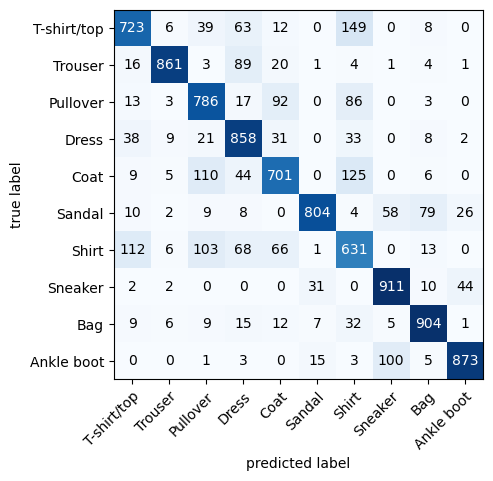

In [120]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=class_names)
plt.show()

### Save and load best performing model

In [121]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [122]:
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.4349,  0.3180, -0.7036],
                        [-0.0341,  0.3113,  0.0789],
                        [-0.2635,  0.0932,  0.3595]]],
              
              
                      [[[-0.3983,  0.5412, -0.2998],
                        [ 0.0964,  0.3102,  0.2982],
                        [-0.0928,  0.3589,  0.0151]]],
              
              
                      [[[-0.3202, -0.2669,  0.2302],
                        [-0.9930, -0.9082,  0.2116],
                        [-0.9946, -0.8716, -0.1723]]],
              
              
                      [[[-0.8757, -1.5244, -0.7128],
                        [ 0.4102, -0.8435,  0.1852],
                        [ 0.2874, -0.2983,  0.5591]]],
              
              
                      [[[-0.0948,  0.1717, -0.2878],
                        [-0.3367,  0.1225, -0.3439],
                        [-0.2017,  0.2074,  0.0457]]],
              
              
      

In [123]:
# Create a new instance of the model
loaded_model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names))

# Load the saved model_state_dict() into the new instance
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to the same device as original model
loaded_model_2.to(device)


/tmp/ipykernel_108979/744214967.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [124]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3164254128932953,
 'model_acc': 88.49840255591054}

In [125]:
# Evaluate loaded model
loaded_model_2_results = eval_model(model=loaded_model_2,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3164254128932953,
 'model_acc': 88.49840255591054}

In [126]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]), torch.tensor(loaded_model_2_results["model_loss"]))


tensor(True)